In [22]:
import functions as f 

import pandas as pd
import numpy as np

from sklearn import metrics
from math import sqrt

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [23]:
# Read dataset
file_path = 'BTCEUR.csv'
df = pd.read_csv(file_path)
df.head()

,Unnamed: 0,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused_field
0,0,1578038400000,6244.33,6244.33,6244.33,6244.33,0.002000,1578038459999,12.488660,1,0.002000,12.488660,0
1,1,1578038460000,6437.82,6437.82,6433.99,6433.99,0.064656,1578038519999,416.067862,2,0.000000,0.000000,0
2,2,1578038520000,6433.99,6433.99,6433.99,6433.99,0.000000,1578038579999,0.000000,0,0.000000,0.000000,0
3,3,1578038580000,6478.91,6478.91,6478.91,6478.91,0.064122,1578038639999,415.440667,1,0.064122,415.440667,0
4,4,1578038640000,6478.91,6478.91,6478.91,6478.91,0.000000,1578038699999,0.000000,0,0.000000,0.000000,0


In [24]:
#Transform and prepare dataset 
df.drop('Unnamed: 0', axis=1, inplace=True)
df['date'] = df['timestamp'].apply(lambda x:f.unix_to_date(x))
df['time'] = df['timestamp'].apply(lambda x:f.unix_to_time(x))
df['datetime'] = df['timestamp'].apply(lambda x:f.unix_to_datetime(x))
df.set_index("datetime", inplace = True)


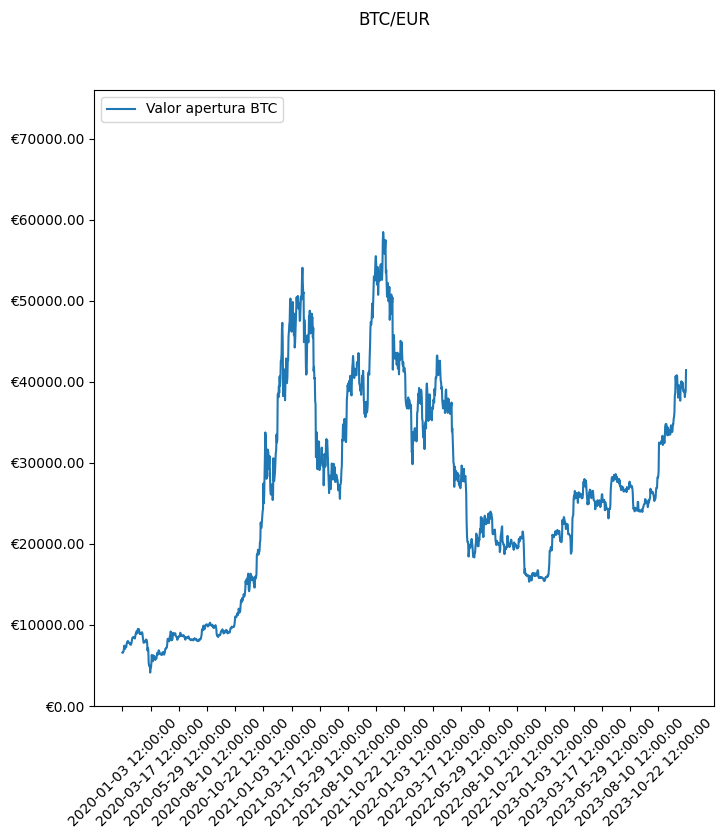

In [25]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Filter the DataFrame to include only rows where the time is 12:00:00
df_plot = df[df['time'] == "12:00:00"]
x = df_plot.index
y = df_plot["open"]

fig = plt.figure(figsize=(8, 8))
ax1 = fig.subplots(1, 1)

ax1.plot(x, y, label="Valor apertura BTC")
# ax1.plot(x, y_media, label="Media de la Serie Original")
ax1.set_ylim(0, np.max(y)*1.3)

# Format y-axis labels with € symbol
def euros(x, pos):
    return f"€{x:.2f}"

formatter = FuncFormatter(euros)
ax1.yaxis.set_major_formatter(formatter)

# Set x-axis ticks and labels at intervals
interval = 73  # Set the interval for displaying ticks
ax1.set_xticks(x[::interval])  # Display ticks at every 'interval' data points
ax1.set_xticklabels(x[::interval], rotation=45)  # Set labels for the ticks and rotate them for better visibility

ax1.legend(loc="upper left")
fig.suptitle("BTC/EUR")
plt.show()


In [26]:
# Filter the DataFrame to include only rows where the time is 12:00:00
df_filtered = df[df['time'] == "12:00:00"]['open']

#Train test split
to_row = int(len(df_filtered)*0.9)
print(to_row)

train_data = df_filtered[0:to_row]
test_data = df_filtered[to_row:]

1314


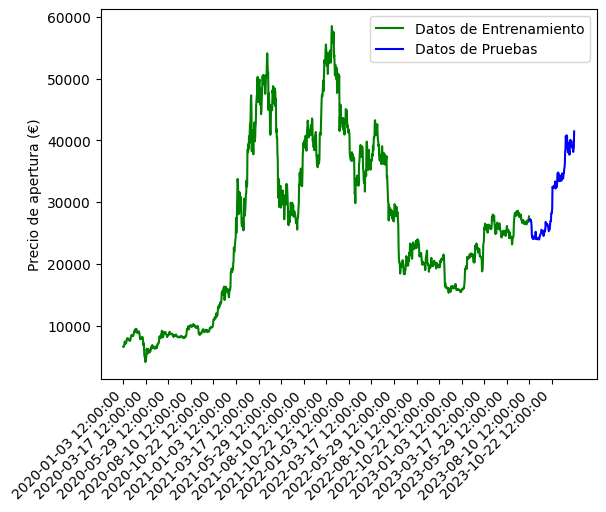

In [27]:
import matplotlib.pyplot as plt

# Plotting train and test data
plt.ylabel('Precio de apertura (€)')
plt.plot(train_data, 'green', label='Datos de Entrenamiento')
plt.plot(test_data, 'blue', label='Datos de Pruebas')

# Ajustar los ticks del eje X para que se muestren cada 73 valores
x_ticks = range(0, len(train_data) + len(test_data), 73)
plt.xticks(x_ticks, rotation=45, ha='right')  # Mostrar los ticks del eje X en diagonal

plt.legend()
plt.show()


In [28]:
model_predictions = []
n_tester_obser = len(test_data)

train_data = train_data.tolist()
test_data = test_data.tolist()

for i in range(n_tester_obser):
    model = ARIMA(train_data, order = (4,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    model_predictions.append(output)
    actual_test_value = test_data[i]
    train_data.append(actual_test_value)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1459
Model:                 ARIMA(4, 1, 0)   Log Likelihood              -12166.239
Date:                Mon, 08 Apr 2024   AIC                          24342.478
Time:                        14:30:20   BIC                          24368.902
Sample:                             0   HQIC                         24352.336
                               - 1459                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0685      0.019     -3.674      0.000      -0.105      -0.032
ar.L2          0.0246      0.020      1.214      0.225      -0.015       0.064
ar.L3         -0.0316      0.016     -1.938      0.0

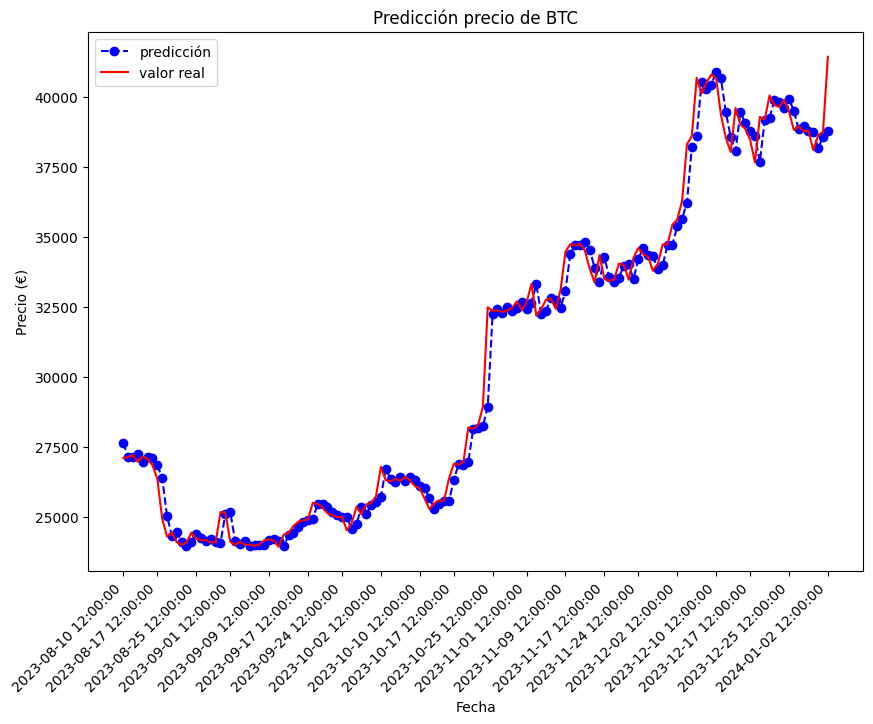

In [36]:
plt.figure(figsize=(10, 7))

date_range = df_filtered[to_row:].index

plt.xlabel('Fecha')
plt.ylabel('Precio (€)')
plt.title('Predicción precio de BTC')

plt.plot(date_range, model_predictions, color='blue', marker='o', linestyle='dashed', label='predicción')
plt.plot(date_range, test_data, color='red', label='valor real')

# Generar 73 ticks equidistantes
tick_indices = np.linspace(0, len(date_range) - 1, 20, dtype=int)
plt.xticks(date_range[tick_indices], rotation=45, ha='right')

plt.legend()
plt.show()